# Contents
1. Problem and data analysis/visualization
2. Preprocessing and feature extraction
3. Training/validation/test split strategy
4. Model training
5. Optimization and hyperparameter tuning
6. Optimization and hyperparameter tuning

# 1. Problem and data analysis/visualization

We are given data related to appliance energy consumption. The objective of the machine learning assignment is to predict the appliance value of a house given certain features such as datetime, temperatures, humudities etc.
Each record of the data is one measurement. Measurements were taken every 10 minutes.


There are two data files: train.csv and test.csv. The test data does not contain appliance values and will be used for the kaggle competition.


Machine learning problems can be grouped in two categories: classification and regression problems. They can also be split up into supervised and non-supervised taks. Since the data already contains the correct solotion (= appliances value) and the appliances are continous, we will thus use algorithms that work for supervised regression. 


## 1.1 Potential algorithms: 
Some known machine learning regression algorithms are the following:
- Linear regression
- Decision tree regression
- Stochastic Gradient Descent (SGD)
- Support vector regression (SVR)
- Lasso regression
- Random forest
- LSTM Time Series Forecasting


We start with two simple models: decision tree regression and linear regression. These will set the baseline for comparing them to more complex algorithms. We with decision tree regression since it was covered in class and it is easy to implement by using the code from the lab sesion. We then try a linear regression algorithm as it known to work well on time series data.

Sources:
- https://www.analyticsvidhya.com/blog/2021/05/5-regression-algorithms-you-should-know-introductory-guide/
- https://www.jigsawacademy.com/popular-regression-algorithms-ml/#KNN-Model-
- https://otexts.com/fpp2/regression.html

----

## 1.2 Datavisualisation

### 1.2.1 Training data description


The data contains 15000 measurements from the period: 01/11/2016 untill 24/04/2016. These are measurements of four months, of 105 different day. Each day contains 144 measure. This is one measure every ten minutes.

Below, a table can be seen that shows the data we are given. All the features contain numbers, except the feature "date" which is of the type datetime. This must be taken into consideration when feeding a model with this data. Not every model is can handle the datetime so we will adapt it.

| | Column | Data type |
| --- | --- | --- |
| 1  |  date |          datetime |
| 2  |  T1 - T9 |       float64 |
| 3  |  RH_1 - RH_9 |   float64 |
| 20 |  T_out |         float64 |
| 21 |  Press_mm_hg |   float64 |
| 22 |  RH_out |        float64 |
| 23 |  Windspeed |     float64 |
| 24 |  Visibility |    float64 |
| 25 |  Tdewpoint |     float64 |
| 26 |  rv1 |           float64 |
| 27 |  rv2 |           float64 |
| 28 |  lights |        int64 |
| 29 |  Appliances |    int64 | 

No data is missing, so we won't have to think of strategies to manage this. 

In [1]:
# numerical library:
import numpy as np
import math

# data manipulation library:
import pandas as pd

# standard packages used to handle files:
import sys
import os 
import glob
import time

# scikit-learn machine learning library:
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

# plotting:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# styling
plt.style.use('ggplot')

data_folder = "./"
def loadData():
    data = pd.read_csv(data_folder + "train.csv")
    return data
                              
    
data = loadData()

In [2]:
# prepareX creates some extra features based on the date.
def prepareX(data):
    # Some transformations to date that will be useful for visualizing and training     
    data['date'] = pd.to_datetime(data['date'])
    data['date-short'] = pd.to_datetime(data["date"].dt.strftime('%Y-%m-%d'))

    data['day'] = pd.to_numeric(pd.to_datetime(data["date"]).dt.strftime('%d'))
    data['month'] = pd.to_numeric(pd.to_datetime(data["date"]).dt.strftime('%m'))
    data['hour'] = pd.to_numeric(pd.to_datetime(data["date"]).dt.strftime('%H'))
    data['minute'] = pd.to_numeric(pd.to_datetime(data["date"]).dt.strftime('%M'))

    data['minute'] = data['minute'] // 10
    data['day'] = data['day'] - 1 # such that everything starts at 0
    data['month'] = data['month'] - 1 # 0 based
    
    return data

# prepareY will subtract the lights value from the appliances.
def prepareY(data):
    return data['Appliances'] - data['lights']
    
data = prepareX(data)

In [3]:
print("Earliest date: " + str(data['date'].min()))
print("Latest date: " + str(data['date'].max()))
print(str(len(pd.unique(data['date-short']))) + " different days")

print("\n")

print("Measure count every day:")
print(data.pivot_table(columns=['date-short'], aggfunc='size'))

Earliest date: 2016-01-11 17:00:00
Latest date: 2016-04-24 20:50:00
105 different days


Measure count every day:
date-short
2016-01-11     42
2016-01-12    144
2016-01-13    144
2016-01-14    144
2016-01-15    144
             ... 
2016-04-20    144
2016-04-21    144
2016-04-22    144
2016-04-23    144
2016-04-24    126
Length: 105, dtype: int64


We split the date field in multiple features. This will make it easier for the model to detect appliances. Eg at night there might be less appliances and thus it is easier for the model to detect this, if we have a feature "hour".

### Note:
There is too much data to visualize, so since the data are measures taken every 10 minutes (ordered by date), we will take the first measure of every hour, hence we only take 1/6th of the data. This gives us 2500 records too work with, instead of the large 15000

We must verify that there is no correlation between appliances and minute. The plots for minute and hour can be seen below.
When ignoring the few outliers in the minute graph (the values above 1000 at minute 50), it seems as if the minute feature does not affect appliances. This is even more clear when looking at the hour, which strongly affects the appliances.

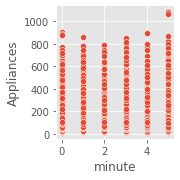

In [4]:
sns.pairplot(data, y_vars="Appliances", x_vars=['minute'])

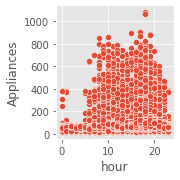

In [5]:
sns.pairplot(data, y_vars="Appliances", x_vars=['hour'])

In [6]:
sample = data[data['minute'] == 0]
len(sample)

2500

Using the following two lines of code, we learn all the data is numeric (except date) and that there are no null values.

data.info()

data.isnull().sum()


### 1.2.2 Distribution:
Taking a look at the distributions of every variable can also give interesting insights. Some algorithms are more sensitive to the distribution than others, so it can be a good idea to normalize this data to a normal distribution. The appliances variable for example, is very skewed. Using the log we normalize this data. We can then obtain the original value again by calculating the exponential. This is demonstrated in the code below. It will later be used in combination with a linear regression model to try and to increate performance.

We see lights and appliances have a very similar distribution. This makes sense because lights is also an appliances value.

In [7]:
data['AppliancesLog'] = np.log(data['Appliances'])
data['AppliancesUnlog'] = np.exp(data['AppliancesLog'])

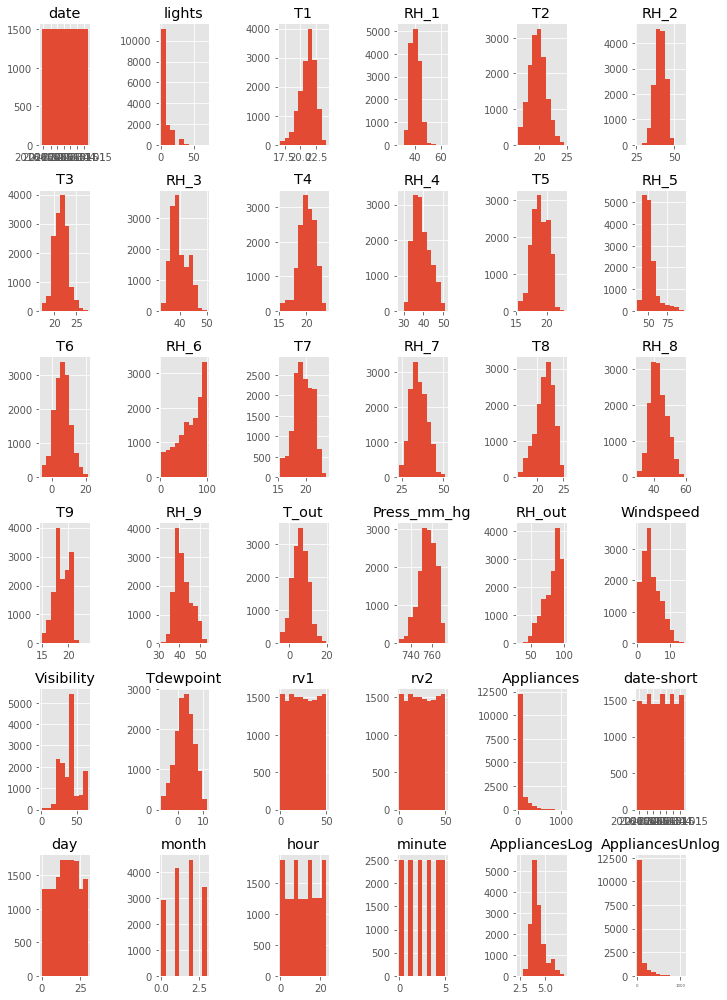

In [8]:
data.hist(figsize = (10,14)) # figsize: (width,height)

plt.xticks(fontsize=4)
plt.tight_layout()
plt.show()

### 1.2.3 Correlations

There is no linear correlation between Appliances and any other feature. Yet we already know that "hour" is somehow correlated to Appliances. We also plot a heatmap that shows all correlation values for every variable below.

In [9]:
# Compute the correlation matrix
corr = sample.corr()
corr['Appliances'] # this is a list of the linear correlation values with Appliances.

corr[ abs(corr['Appliances']) > 0.5 ]
# literally, the only feature that has an R value > 0.5 with respect to Appliances, is appliances.
# nothing has a linear correlation.

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances,day,month,hour,minute
Appliances,0.235419,0.079509,0.080033,0.150881,-0.065203,0.123364,0.034163,0.070513,-0.001948,0.014959,...,0.065091,-0.004365,0.006838,-0.024886,-0.024886,1.0,-0.022521,-0.002377,0.247548,NaN


<AxesSubplot:>

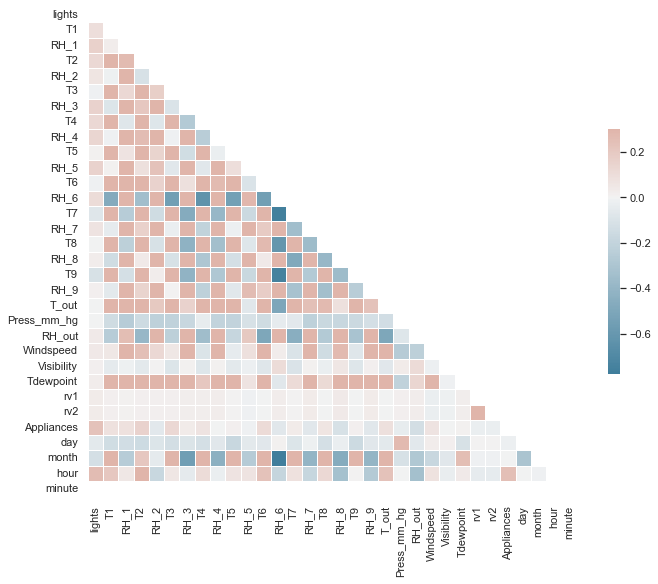

In [10]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)

# Compute the correlation matrix
corr = sample.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Since we couldn't find any linear correlations, we try to look for different kind of correlations by vizualing the paired plots. Doing so tells us that the hour variable for example does have inffluence on appliances. Between 10am and 8pm the appliance values are more extreme and go a lot higher than during the night for example.

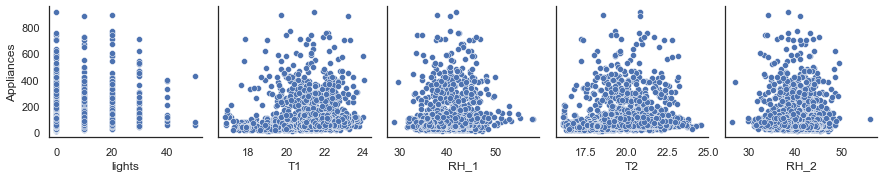

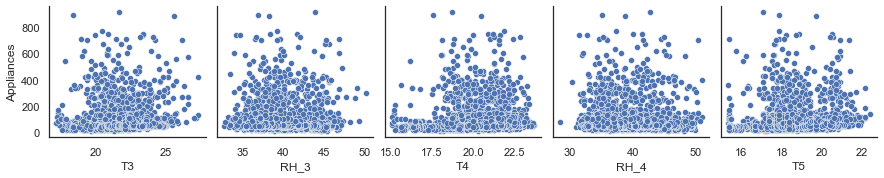

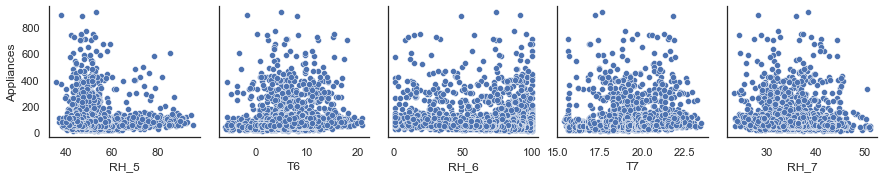

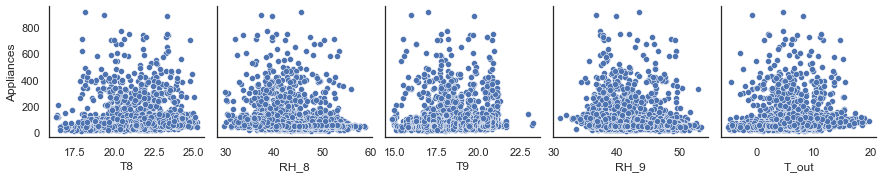

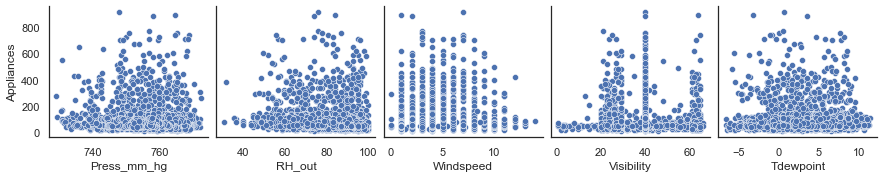

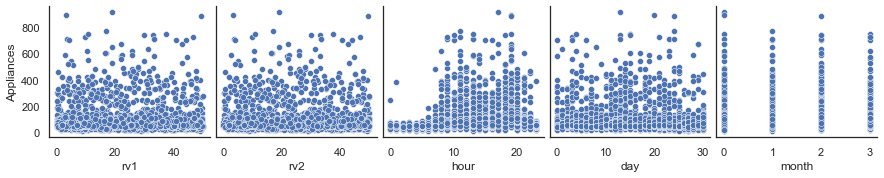

In [11]:
features = [
    'lights', 'T1', 'RH_1',
    'T2', 'RH_2',
    'T3', 'RH_3',
    'T4', 'RH_4',
    'T5', 'RH_5',
    'T6', 'RH_6',
    'T7', 'RH_7',
    'T8', 'RH_8',
    'T9', 'RH_9',
    'T_out', 'Press_mm_hg',
    'RH_out', 'Windspeed',
    'Visibility', 'Tdewpoint',
    'rv1', 'rv2',
    'hour', 'day',
    'month']

cols = 5
for idx in range(0, math.ceil(len(features) / cols)):
    sns.pairplot(sample, y_vars="Appliances", x_vars=features[idx*cols:(idx*cols)+cols])

### 1.2.4 More data visualizations
To get an idea of the trendline of the appliances over the different months, we take the average of appliances every day and plot it over the date. The graphs below show that not much changes over the time. Values in January are similar to values in April.

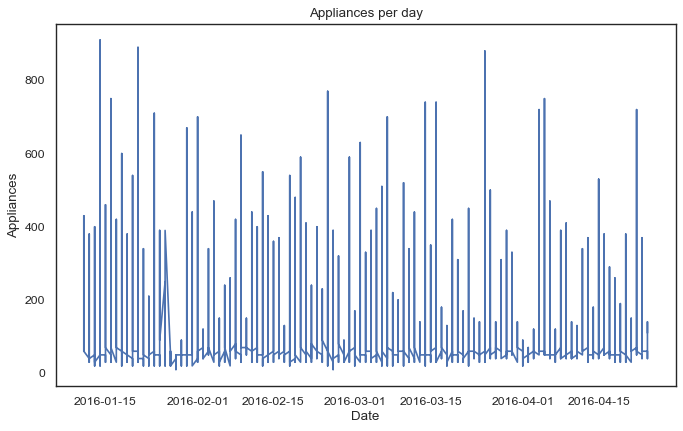

In [12]:
# Too many ups and downs, so it is hard to see the trendline here.
# We improve this in the next graph

figure(figsize=(10, 6), dpi=80)
plt.plot(sample['date-short'], sample['Appliances'])


plt.title("Appliances per day")
plt.xlabel("Date")
plt.ylabel("Appliances")
plt.show()

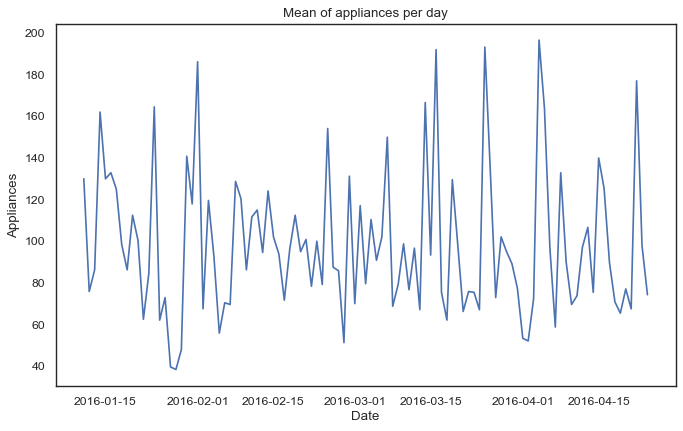

In [13]:
# Plot the mean of appliances per day
figure(figsize=(10, 6), dpi=80)

meanPerDay = sample.groupby('date-short', as_index=False)['Appliances'].mean()
plt.plot(meanPerDay['date-short'], meanPerDay['Appliances'])

plt.title("Mean of appliances per day")
plt.xlabel("Date")
plt.ylabel("Appliances")
plt.show()

In [14]:
# differentDates = sample['date-short'].unique()
# # len(differentDates)
# # sample['hour'].unique()
# differentDates

In [15]:
# one = sample[sample['date-short']=='2016-01-21']
# one['Appliances'].values

# two = sample[sample['date-short']=='2016-01-22']
# two['Appliances'].values

# l = [one['Appliances'].values, two['Appliances'].values]
# y_mean = np.mean(l, axis=0)


# # plt.plot(oneDay['hour'], oneDay['Appliances'])

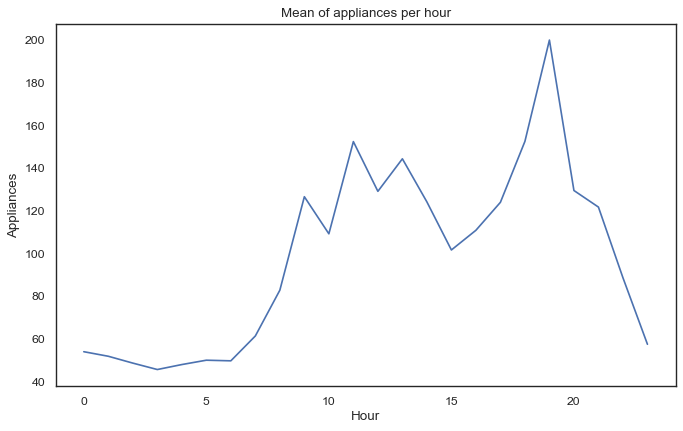

In [16]:
figure(figsize=(10, 6), dpi=80)

differentDates = sample['date-short'].unique()
# remove first day and and last day because those two days don't have measures of all entire day
# differentDates.pop(0)
# differentDates.pop(len(differentDates) - 1)

length = len(differentDates)
differentDates = differentDates[1: length - 1]

hours = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
appliances = []
for date in differentDates:
    oneDay = sample[sample['date-short']==date]
    appliances.append(oneDay['Appliances'].values)
    
means = np.mean(appliances, axis=0)

plt.title("Mean of appliances per hour")
plt.xlabel("Hour")
plt.ylabel("Appliances")
plt.plot(hours, means)
plt.show()

As we noticed earlier that the hour variable might play a significant role in the appliances, we want to plot a trendline of the average appliances value at a given time. The graph is displayed above. It clearly shows that the appliances are much higher from 10am to 3 pm and then again from 5pm to 8pm.

### 1.2.4 feature importance
To determine what features to use in our model, we use decision trees to calculate feature importance. This is done in the code below. From the graph, we notice hour plays a significant role, which we already knew. The graph also tells us that variables T3 and lights have significant impact on appliances. We also notice multiple plots that have very little impact. When taking a closer look at these variables, we notice rv1 and rv2 are exactly the same and don't have any meaning. We will remove those two variables before feeding it to our models.

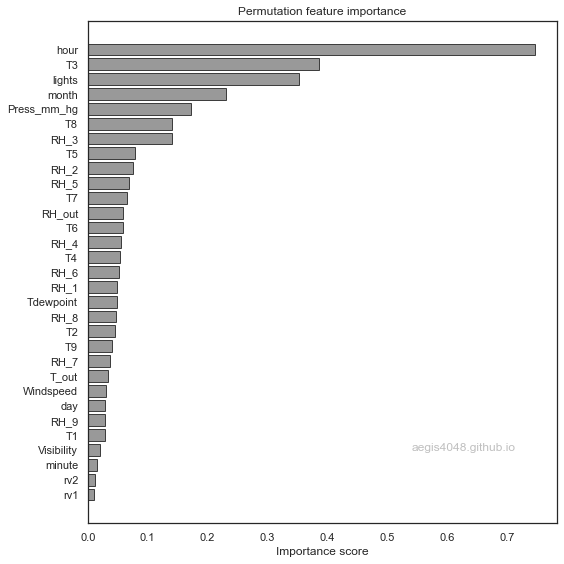

In [17]:
# Copied from:
# https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python

import rfpimp
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

##### Data preparation #####

features = [
    "lights",
    "day",
    "month",
    "hour",
    "minute",
    "T1", "RH_1", 
    "T2", "RH_2", 
    "T3", "RH_3", 
    "T4", "RH_4", 
    "T5", "RH_5", 
    "T6", "RH_6", 
    "T7", "RH_7", 
    "T8", "RH_8", 
    "T9", "RH_9",
    "T_out", "Press_mm_hg",
    'RH_out',             
    'Windspeed',          
    'Visibility',         
    'Tdewpoint',          
    'rv1',                
    'rv2']


##### Train #####

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(data[features], data['Appliances'])

##### Permutation feature importance #####

imp = rfpimp.importances(rf, data[features], data['Appliances'])

##### Plot #####

fig, ax = plt.subplots(figsize=(8, 8))

ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k')
ax.set_xlabel('Importance score')
ax.set_title('Permutation feature importance')
ax.text(0.8, 0.15, 'aegis4048.github.io', fontsize=12, ha='center', va='center',
        transform=ax.transAxes, color='grey', alpha=0.5)
plt.gca().invert_yaxis()

fig.tight_layout()

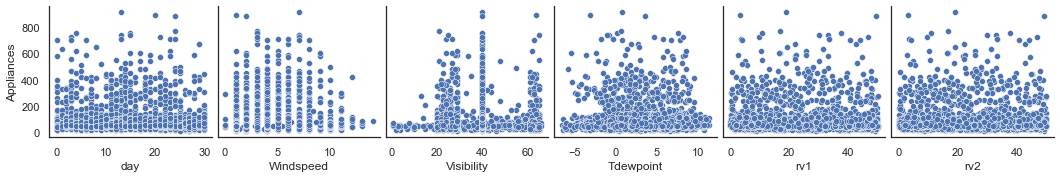

In [18]:
# Taking a look at the correlations for the worste performing features
sns.pairplot(sample, y_vars="Appliances", x_vars=[
    'day',
    'Windspeed',
    'Visibility',
    'Tdewpoint',
    'rv1',
    'rv2'])

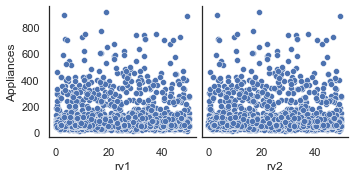

In [19]:
sns.pairplot(sample, y_vars="Appliances", x_vars=[
    'rv1',
    'rv2'])

# Rv1 and rv2 are exacly the same and are random variables, they have no meaning

# 2. Preprocessing and feature extraction

According to the article, linked below, it is not recommented to simply remove features if no noticable relationship can be found. This is because the relationship can not always be seen from a scatterplot. The statement also seems to hold when training the model on the most imporant features.

Different approach, which also isn't recommended is multi lin regression on all features and disregard all variables whos p-values are greated than 0.05. P-values can be misleading since variables can be corrolated.


What we will do it train the model on the powerset of features and see what gives the best results.
The two features rv1 and rv2 will ofcourse not be part of the model as they are meaningless.

## 2.1 Date
As stated earlier, not every model is able to work with a datetime type. For example, the linear regression algorithm expects all data to be numeric. The date variable will be split into features: month, day, hour, minute. Each feature is also transformed so that it starts at 0 increments by 1. For example the minute field which originally contained values: 00, 10, 20, 30, 40, 50 will now contain values: 0, 1, 2, 4, 5. The hour feature also appears to be very imporant by the model, as noted earlier by the RandomForestRegressor we used.

## 2.2 Lights
The data contains a feature lights. This value can be subtracted from the appliances value. Doing so improves the linear regression model by 1 (eg from RMSE of 97 to an RMSE of 96). 


https://otexts.com/fpp2/selecting-predictors.html

# 3. Training/validation/test split strategy

## 3. 1 Data shuffling
In many machine learning problems it is a common practice to first shuffle the data and then split it into a training set and a validation set. The issues with this approach is that the data points may be too similar. For example if a measure was taken at 2:00am and a second measure at 2:10am, the appliances value may be very similar, maybe even identic. By shuffling the data we risk giving the training data the 2:00am measure and the validation data the 2:10am measure. This way we risk testing the model on data which is practically identical to the training data. If the model would overfit, this would not be detected by comparing training loss and validation loss as they would both be great numbers. We thus are not allowed to shuffle the data.

## 3.2 Cross validation
Cross validation is a nice way to train a model and get robust performance metrics. However the standard method does not work for time series data. With normal K-fold cross validation, the first 10% of data may be selected as training data and then the other 90% as training data. Although this approach works for non time series problems, it does not for time series. It simply doesn't make sense to predict the past based on data from the future. The image below demonstrates normal K-fold cross validation.

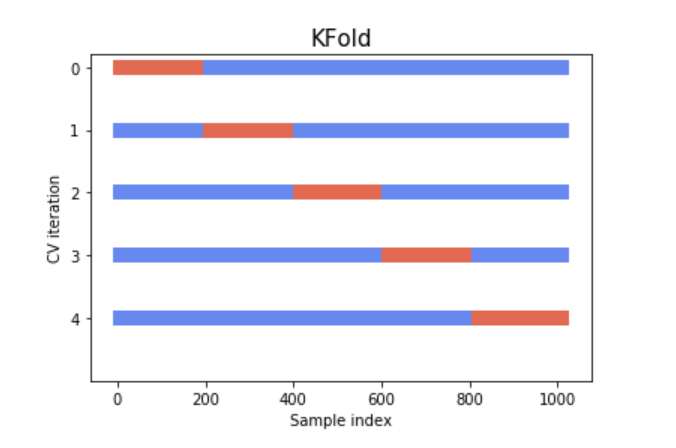

Source: https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

Instead we must use a different technique where the testing data is not earlier than the training data. Via sklearn time series split, we will have the benefit of normal cross validation with multiple tests, but we will also make sure the testing data is always in the future. An image of this technique can be seen below.

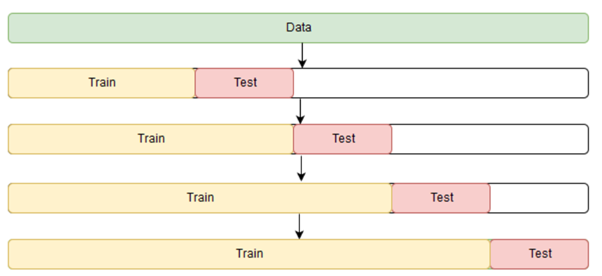

Source: https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

## 3.2 Feature engineering

### 3.2.1 Feature selection
Earlier in the notebook we generated a graph that represented the importance of every feature. The graph can be seen below.
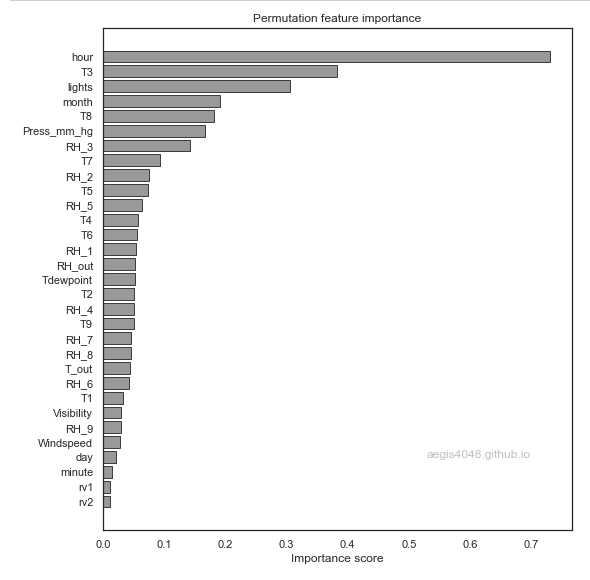

Multiple attempts to improve accuracy of the model were done. Below we can see the code of different features that were used to train models.

In [20]:
def selectAllFeatures(data):
    return data[[
        "lights",
        "day",
        "month",
        "hour",
        "minute",
        "T1", "RH_1", 
        "T2", "RH_2", 
        "T3", "RH_3", 
        "T4", "RH_4", 
        "T5", "RH_5", 
        "T6", "RH_6", 
        "T7", "RH_7", 
        "T8", "RH_8", 
        "T9", "RH_9", 
        "T_out", "Press_mm_hg",
        'RH_out',             
        'Windspeed',          
        'Visibility',         
        'Tdewpoint'        
        'rv1',                
        'rv2'
    ]]

def selectMostImporantFeatures(data):
    # this performs worse than taking all the data
    return data[
    [
    "lights",
     "hour",
     "minute",
     "T3", "RH_3", 
     "T_out", 
     "Press_mm_hg",        
    ]]


# currently the best performing option:
# take all features except random variable 1, random variable 2, lights.
# the value of lights is subtracted from the appliances value, 
# just before giving it to the model for training.
def selectFeatures(data):
    return data[
    [
        # remove lights         
        #"lights",
        "day",
        "month",
        "hour",
        "minute",
        "T1", "RH_1", 
        "T2", "RH_2", 
        "T3", "RH_3", 
        "T4", "RH_4", 
        "T5", "RH_5", 
        "T6", "RH_6", 
        "T7", "RH_7", 
        "T8", "RH_8", 
        "T9", "RH_9", 
        "T_out", "Press_mm_hg",
        'RH_out',             
        'Windspeed',          
        'Visibility',         
        'Tdewpoint'        
        #remove rnd vars
        #'rv1',                
        #'rv2'
    ]]

### 3.2.2 Transformation of the data:
normalization van zowel x als y

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

def preprocess(selectFeaturesFunction, prepareXFunction, prepareYFunction, 
               normalizeX = False, 
               normalizeY = False,
               scaleX = False):

    data = loadData()
    data = prepareXFunction(data)

    xs = selectFeaturesFunction(data)
    ys = prepareYFunction(data) 
    
    # Note that taking the log of the ys will result in smaller y values and thus the residu's of our predictions will be smaller.
    # This means we will have a lower RMSE but it won't necessarly mean the model is better.
    # Therefore we also look at R^2 metrics.
    
    if normalizeY:   
        ys = np.where(ys != 0, np.log(ys), 0) # prevents errors where y equals 0
        
    
    if normalizeX:
        # normalization must happen after preparing Ys
        xs = normalize(xs)
    
    if scaleX:
        # I tried scaling, but it doesn't seem to affect results
        scale = StandardScaler()
        xs = scale.fit_transform(xs)


    nsamples = xs.shape[0]
    
    return xs, ys, nsamples

### 3.2.3 Data splitting:
normalization van zowel x als y

In [22]:
def trainTestSplit():
    split = int(math.floor(0.8*nsamples)) #use 80% of samples as training set

    #these samples are used to train the model
    xs_train = xs[0:split]
    ys_train = ys[0:split]

    #these are used to evaluate the model
    xs_test = xs[split:nsamples]
    ys_test = ys[split:nsamples]
    
    return xs_train, ys_train, xs_test, ys_test


In [23]:
def evaluate(y_true, y_pred):
    # calculate RMSE    
    return math.sqrt(mean_squared_error(y_true, y_pred))

In [24]:
def trainAndTest(model):
    model_name = type(model()).__name__
    
    m = model()
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    scores = cross_val_score(m, xs, ys, cv=cv, scoring='neg_root_mean_squared_error')
    

    reg = m.fit(xs_train, ys_train)
    
    print(model_name)
    print("RMSE (train): " + str(evaluate(ys_train, reg.predict(xs_train))))
    print("R2 (train): " + str(reg.score(xs_train, ys_train)))
    print("")
    
    print("RMSE (test): " + str(evaluate(ys_test, reg.predict(xs_test))))
    print("R2 (test): " + str(reg.score(xs_test, ys_test)))
    print("")
    
    print("Cross validation RMSE: " +  str(abs(scores.mean())))
    
    return reg

### 3.2.4 Model performance visualization:
The following code will be used to look at model performance over time

In [25]:
def plot_graph_over_time(xs_train, xs_test, ys_train, ys_copy):
    # Plot the mean of appliances per day and compare to predictions
    figure(figsize=(10, 6), dpi=80)

    xs_train_copy = xs_train.copy()
    xs_train_copy['Appliances'] = ys_train.copy()
    xs_train_copy['AppliancesPred'] = reg.predict(xs_train)


    xs_test_copy = xs_test.copy()
    xs_test_copy['Appliances'] = ys_test.copy()
    xs_test_copy['AppliancesPred'] = reg.predict(xs_test)


    train_meanPerDay = xs_train_copy.groupby(['day', 'month'], as_index=False)['Appliances'].mean()
    train_meanPerDayPred = xs_train_copy.groupby(['day', 'month'], as_index=False)['AppliancesPred'].mean()
    train_meanPerDay_len = len(train_meanPerDay)

    test_meanPerDay = xs_test_copy.groupby(['day', 'month'], as_index=False)['Appliances'].mean()
    test_meanPerDayPred = xs_test_copy.groupby(['day', 'month'], as_index=False)['AppliancesPred'].mean()
    test_meanPerDay_len = len(test_meanPerDay)

    plt.plot(list(range(0, train_meanPerDay_len)), train_meanPerDay['Appliances'], label='Actual train val')
    plt.plot(list(range(0, train_meanPerDay_len)), train_meanPerDayPred['AppliancesPred'], label='Training Prediction')

    plt.plot(list(range(train_meanPerDay_len, train_meanPerDay_len + test_meanPerDay_len)), test_meanPerDay['Appliances'], label='Actual test val')
    plt.plot(list(range(train_meanPerDay_len, train_meanPerDay_len + test_meanPerDay_len)), test_meanPerDayPred['AppliancesPred'], label='Testing Prediction')

    plt.legend()
    plt.title("Actual values vs predictions")
    plt.xlabel("Time")
    plt.ylabel("Day count")
    plt.show()

# 4. Model training and hyperparameter tuning

Multiple regression algorithms were used to predict appliances. As explained in the introduction, we started with decision trees and linear regression. We then compared those results to other algorithms with the following algorithms: SGDRegressor, SVR and gradient boosting regression. As the linear regression technique scored the best in comparision to the others, a lot of focus was put into optimizing this technique. The intial scoring was doing using RMSE.

## 4.1 DECISION TREE

In [26]:
from sklearn.tree import DecisionTreeRegressor

xs, ys, nsamples = preprocess(selectFeatures, 
                              prepareX, 
                              prepareY) # subtract lights from result
                             
xs_train, ys_train, xs_test, ys_test = trainTestSplit()
reg = trainAndTest(DecisionTreeRegressor)

DecisionTreeRegressor
RMSE (train): 0.0
R2 (train): 1.0

RMSE (test): 158.5580860967572
R2 (test): -1.0714050884890929

Cross validation RMSE: 95.85789561870084


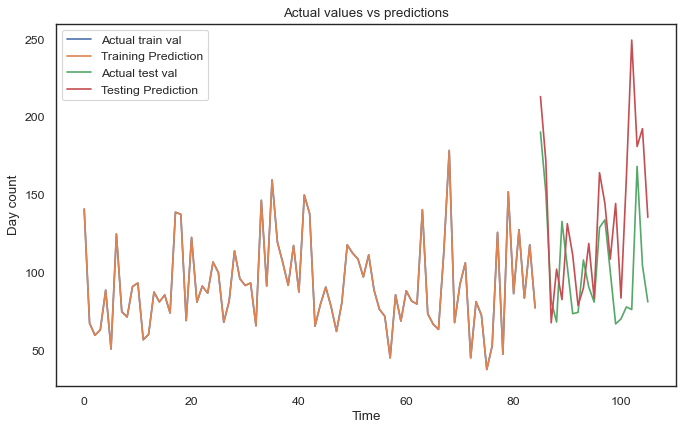

In [27]:
plot_graph_over_time(xs_train, xs_test, ys_train, ys_test)

As we can see in the graph above, the decision tree model perfectly fits the training set. This means the model is clearly overfitting. Also when we look at the performance of the on the testing set, the peeks do happen at the right time, however they are much extremer compared to the actual values.

To resolve these issues, we must first handle the overfitting and maybe also take a look at removing outliers. The overfitting is probably related to the depth of the tree. To try resolve this issue we could make use of pruning techniques. These techniques however, are not implemented.

Since the linear regression algoirthm covered in the next section performed a lot better out of the box, most analaysis was done on that algorithm.

# 4.2 LINEAR REGRESSION

Linear regression is known for doing well on time series data. The algorithm draws a linear line that best fits the data. Since we have multiple independent variables, we really use multi linear regression instead of linear regression.


## 4.2.2 Training

In [28]:
from sklearn.linear_model import LinearRegression

xs, ys, nsamples = preprocess(selectFeatures, 
                              prepareX, 
                              prepareY) # subtract lights from result
                             
xs_train, ys_train, xs_test, ys_test = trainTestSplit()
reg = trainAndTest(LinearRegression)

LinearRegression
RMSE (train): 95.86133279099779
R2 (train): 0.1399929681548986

RMSE (test): 102.63821548429465
R2 (test): 0.13202656380698585

Cross validation RMSE: 98.76320023869889


| Manual attempt | RMSE |
|---|---|
| All features, including custom date features | 97.62890559708477 | 
| All features, including custom date features, normalized | 97.58777616071994 | 
| All features, including custom date features, subtract lights from appliances | 97.58777616071994 | 
| All features, including custom date features, subtract lights from appliances, normalized | 97.58777616071994 | 
| 5 best most important features (based on Decision tree graph above) | 99.84627682593535 | 
| All features, without random vars 1 and 2 | 96.74245969782177 | 
| Normalize y values by taking log (RMSE is not comparable because of logs) | 0.6129467586433395 | 


## 4.2.2 Evaluation

Currently, the best performing model has an RMSE of 96 and an $R^2$ of 0.2. Although the models' RMSE perform slightly better than the all mean solution, the $R^2$ of 0.2 is problematic. This means that are independent variables do not influence the dependent variable at all. An $R^2$ of 0.2 is only slightly better than a horizontal line, which has $R^2$ = 0.

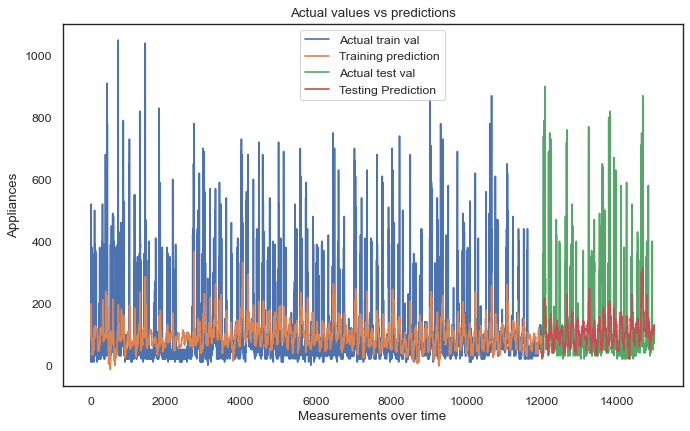

In [29]:
# Compare predictions vs actual results over time

fig, ax = plt.subplots(figsize=(10, 6), dpi=80)

train_len = len(xs_train)
test_len = len(xs_test)

ax.plot(list(range(0, train_len)), ys_train, label='Actual train val')
ax.plot(list(range(0, train_len)), reg.predict(xs_train), label='Training prediction')

ax.plot(list(range(train_len, train_len + test_len)), ys_test, label='Actual test val')
ax.plot(list(range(train_len, train_len + test_len)), reg.predict(xs_test), label='Testing Prediction')

plt.legend()
plt.title("Actual values vs predictions")
plt.xlabel("Measurements over time")
plt.ylabel("Appliances")
plt.show()

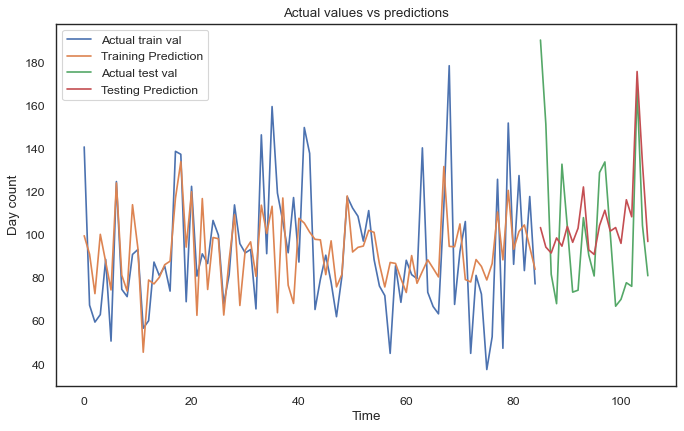

In [30]:
# Plot the mean of appliances per day and compare to predictions
figure(figsize=(10, 6), dpi=80)

xs_train_copy = xs_train.copy()
xs_train_copy['Appliances'] = ys_train.copy()
xs_train_copy['AppliancesPred'] = reg.predict(xs_train)


xs_test_copy = xs_test.copy()
xs_test_copy['Appliances'] = ys_test.copy()
xs_test_copy['AppliancesPred'] = reg.predict(xs_test)


train_meanPerDay = xs_train_copy.groupby(['day', 'month'], as_index=False)['Appliances'].mean()
train_meanPerDayPred = xs_train_copy.groupby(['day', 'month'], as_index=False)['AppliancesPred'].mean()
train_meanPerDay_len = len(train_meanPerDay)

test_meanPerDay = xs_test_copy.groupby(['day', 'month'], as_index=False)['Appliances'].mean()
test_meanPerDayPred = xs_test_copy.groupby(['day', 'month'], as_index=False)['AppliancesPred'].mean()
test_meanPerDay_len = len(test_meanPerDay)

plt.plot(list(range(0, train_meanPerDay_len)), train_meanPerDay['Appliances'], label='Actual train val')
plt.plot(list(range(0, train_meanPerDay_len)), train_meanPerDayPred['AppliancesPred'], label='Training Prediction')

plt.plot(list(range(train_meanPerDay_len, train_meanPerDay_len + test_meanPerDay_len)), test_meanPerDay['Appliances'], label='Actual test val')
plt.plot(list(range(train_meanPerDay_len, train_meanPerDay_len + test_meanPerDay_len)), test_meanPerDayPred['AppliancesPred'], label='Testing Prediction')

plt.legend()
plt.title("Actual values vs predictions")
plt.xlabel("Time")
plt.ylabel("Day count")
plt.show()

### 4.2.3 Observations
If we look at the graph above, we can see the model does a decent job at learning the peeks. 
When the training value contains a high value, the prediction is also high. Same for low training values.

On the test data we notice the same; predictions are reach a maximum/minimum when the actual data contains a maximum/minimum.
This is good, however there is still a large distance between some predictions and their actual values.

## 4.3 SGDRegressor
Stochastic gradient decent is also one of the simpler algorithms, such as linear regression and can learn machine learning problems quickly. The algorithm however, is sensitive to feature scaling. This is why we normalize both the X and Y values in in the code below. According to sklearn's documentation, the algorithm also requires a number of hyperparameters such as regularization to be set. We have not done this in our implementation and this might increase performance a bit. As we can see the results are plain terrible. We have not looked into why this is the case.

In [31]:
from sklearn.linear_model import SGDRegressor

xs, ys, nsamples = preprocess(selectFeatures, 
                              prepareX, 
                              prepareY, # subtract lights from result
                              normalizeX = True,
                              normalizeY = True)
                             
xs_train, ys_train, xs_test, ys_test = trainTestSplit()
reg = trainAndTest(SGDRegressor)

# note that we normalize the Y value. This explains the very low RMSE. 
# In reality the RMSE scores are terrible when we do not calcualte the log.

SGDRegressor
RMSE (train): 0.7095551040470157
R2 (train): 0.003794899358517956

RMSE (test): 0.661804116810555
R2 (test): -0.049743209280999956

Cross validation RMSE: 0.7089521337658491


C:\Python\Python39\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 4.4 SVR
- \+ good with outliers
- \+ high prediction accuracy
- \- not good for large datasets
- \- not well against noice

As we can see from the advantages and disadvantages, although the algorithm works well for outliers (which our data has a lot of), it does not perform well for lage datasets. It may be a good idea to look elsewhere to solve our regression problem. The reason we tried the algorithm here is because sklearn offers a simpel api so that we could easily try it out.

In [32]:
from sklearn.svm import SVR

xs, ys, nsamples = preprocess(selectFeatures, 
                              prepareX, 
                              prepareY) # subtract lights from result
                             
xs_train, ys_train, xs_test, ys_test = trainTestSplit()
reg = trainAndTest(SVR)

SVR
RMSE (train): 109.26518860696324
R2 (train): -0.11732294158939705

RMSE (test): 116.9814502711474
R2 (test): -0.1275148001554698

Cross validation RMSE: 112.95272206707561


## 4.5 Gradient Boosting Regressor

Gradient boosting regressor is an algorithm that usually obtains high accuracies. It performs well compared to other techniques such as linear regression. One disadvantage of linear regression is that it is sensitive to outliers, we should try to resolve those to attempt to improve our scores. If we would look further into improving our scores, we would try more things using this algorithm.

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

xs, ys, nsamples = preprocess(selectFeatures, 
                              prepareX, 
                              prepareY, # subtract lights from result                             
                             )

xs_train, ys_train, xs_test, ys_test = trainTestSplit()
reg = trainAndTest(GradientBoostingRegressor)

# The R2 value on the testing data is 0.5. This means the independent variables actually have an effect on the appliances predictions.
# Unfortunately the R2 score is a lot worse on the testing data.

GradientBoostingRegressor
RMSE (train): 80.43598180031586
R2 (train): 0.3944976807573263

RMSE (test): 106.91264550784315
R2 (test): 0.058226640563508125

Cross validation RMSE: 90.1981721019142


# 5 Optimization and hyperparameter tuning
Since the linear regression from earlier obtained the best results, we wil try to optimze its features by selecting the combination of features that give best performance.

It would also a good idea to try and optimize some hyperparameters for Gradient Boosting Regressor. We unfortunately, have not implemented this.

## 5.1 Linear Regression optimization

In [34]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

xs, ys, nsamples = preprocess(selectFeatures, 
                              prepareX, 
                              prepareY) # subtract lights from result
xs_train, ys_train, xs_test, ys_test = trainTestSplit()

featureCount = xs.shape[1]
hyper_params = [{"n_features_to_select": list(range(1, featureCount))}]

m = trainAndTest(LinearRegression)
rfe = RFE(m) # for feature selection

tscv = TimeSeriesSplit(n_splits=3)
model_cv = GridSearchCV(estimator = rfe, # try out different feature counts
                        param_grid = hyper_params, 
                        scoring = 'neg_root_mean_squared_error',
                        cv = tscv,
                        verbose = 1,
                        return_train_score=True)

# scores = cross_val_score(m, xs, ys, cv=tscv, scoring='neg_root_mean_squared_error') #scoring='f1_macro'
model_cv.fit(xs_train, ys_train)

# Source: https://www.kaggle.com/jnikhilsai/cross-validation-with-linear-regression

LinearRegression
RMSE (train): 95.86133279099779
R2 (train): 0.1399929681548986

RMSE (test): 102.63821548429465
R2 (test): 0.13202656380698585

Cross validation RMSE: 98.76320023869889
Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27]}],
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

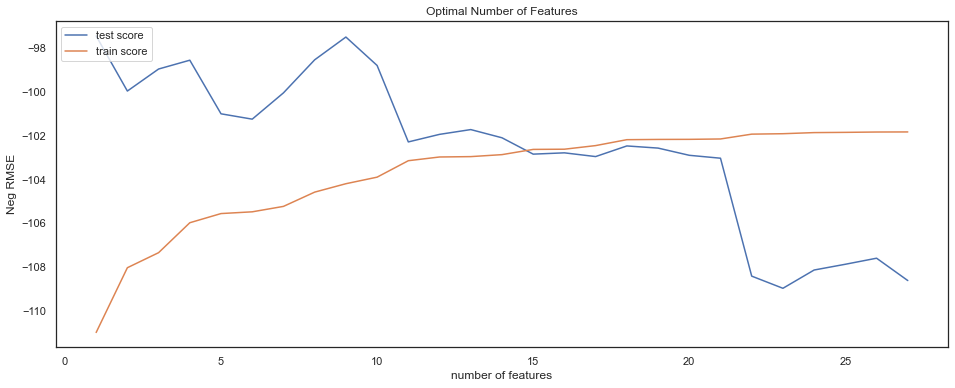

In [35]:
cv_results = pd.DataFrame(model_cv.cv_results_)

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('Neg RMSE')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

The graph above, we take a look at what number of features gives us the best RMSE. Since the values RMSE's are negative, the higher the line, the better. We decide that 14 features is optimal and we use this value to create our final model.

In [44]:
# final model
n_features_optimal = 14

lm = LinearRegression()
lm.fit(xs_train, ys_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(xs_train, ys_train)


xs, ys, nsamples = preprocess(selectFeatures, 
                              prepareX, 
                              prepareY) # subtract lights from result
                             
xs_train, ys_train, xs_test, ys_test = trainTestSplit()

# ys_pred = lm.predict(xs_test)
ys_pred = rfe.predict(xs_test)
r2 = sklearn.metrics.r2_score(ys_test, ys_pred)
rmse = evaluate(ys_test, ys_pred)

print("R2: " + str(r2))
print("RMSE: " + str(rmse))

R2: 0.14487800966897912
RMSE: 101.87553747592438


# 6. PREPARE FOR KAGGLE
Although we have a final model, to obtain an optimal score for the kaggle contest I trained a linear regression model on all the data (including validation data). I am aware that for real world applications, this should never be done. However, for the kaggle content, this meant the model had more data and also had to predict values less far in the future, than that it would otherwise if we used a validation set.

In [37]:
def generate_unique_filename(basename, file_ext):
    """Adds a timestamp to filenames for easier tracking of submissions, 
    models, etc."""
    timestamp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    return basename + '_' + timestamp + '.' + file_ext

# doesnt consider lights
def generate_kaggle(model):
    kaggle_data = pd.read_csv(data_folder + "test.csv")
    kaggle_data = prepareX(kaggle_data)
    kaggle_xs = selectFeatures(kaggle_data)
    

    predictions = model.predict(kaggle_xs)

    submission = pd.DataFrame(data=predictions, columns=["Appliances"])
    submission.index.name = "Id"
    submission.head()

    name = generate_unique_filename("./kaggle_attempts/cust_submission", "csv")
    submission.to_csv(name)
    print("done: " + name)

In [38]:
###### add lights
def generate_kaggle(model):
    kaggle_data = pd.read_csv(data_folder + "test.csv")
    
    kaggle_data = prepareX(kaggle_data)
    kaggle_xs = selectFeatures(kaggle_data)
    # kaggle_xs = normalize(kaggle_xs)

    predictions = model.predict(kaggle_xs)
    predictions = pd.Series(predictions)
    
    # unnormalize    
    # predictions = pd.Series(np.where(predictions != 0, np.exp(predictions), 0))
    
    # add lights value that was
    predictions = predictions + kaggle_data['lights']
    
    submission = pd.DataFrame(data=predictions, columns=["Appliances"])
    submission.index.name = "Id"
    submission.head()

    name = generate_unique_filename("./kaggle_attempts/cust_submission", "csv")
    submission.to_csv(name)
    print("done: " + name)
    
# normalization and add lights 
def generate_kaggleWithNormalization(model):
    kaggle_data = pd.read_csv(data_folder + "test.csv")
    
    kaggle_data = prepareX(kaggle_data)
    kaggle_xs = selectFeatures(kaggle_data)
    # kaggle_xs = normalize(kaggle_xs)

    predictions = model.predict(kaggle_xs)
    predictions = pd.Series(predictions)
    
    # unnormalize    
    predictions = pd.Series(np.where(predictions != 0, np.exp(predictions), 0))
    
    # add lights value that was
    predictions = predictions + kaggle_data['lights']
    
    submission = pd.DataFrame(data=predictions, columns=["Appliances"])
    submission.index.name = "Id"
    submission.head()

    name = generate_unique_filename("./kaggle_attempts/cust_submission", "csv")
    submission.to_csv(name)
    print("done: " + name)

In [39]:
generate_kaggle(rfe)

done: ./kaggle_attempts/cust_submission_20220106-194428.csv
